In [1]:
import pandas as pd
import numpy as np
from word2number import w2n

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../data/data.csv')

In [46]:
#Info from the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

In [47]:
from pandas_profiling import ProfileReport

/home/lucas/projects/auto1_test/venv/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


In [48]:
ProfileReport(data)

Number of variables,26
Number of observations,205
Total Missing (%),0.0%
Total size in memory,41.7 KiB
Average record size in memory,208.4 B
Numeric,9
Categorical,16
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [5]:
#Some features are continuous, however they are set as strings. Need to change that.
def str_to_float(value):
    if value == '?':
        return None
    else:
        return float(value)

In [6]:
data_treat1 = data.copy()
data_treat1['price'] = data['price'].apply(lambda p: str_to_float(p))
data_treat1['normalized-losses'] = data['normalized-losses'].apply(lambda p: str_to_float(p))
data_treat1['peak-rpm'] = data['peak-rpm'].apply(lambda p: str_to_float(p))
data_treat1['horsepower'] = data['horsepower'].apply(lambda p: str_to_float(p))
data_treat1['stroke'] = data['stroke'].apply(lambda p: str_to_float(p))
data_treat1['bore'] = data['bore'].apply(lambda p: str_to_float(p))
data_treat1['num-of-cylinders'] = data['num-of-cylinders'].apply(lambda p: w2n.word_to_num(p))

In [7]:
#Feature Engineering: Segmentation of Fuel Consumption
fuel_cons = data_treat1[['bore', 'fuel-system', 'stroke',
                        'horsepower', 'num-of-cylinders', 'engine-type', 'aspiration',
                        'curb-weight', 'engine-location', 'wheel-base',
                        'fuel-type', 'city-mpg', 'highway-mpg']]

In [8]:
#Verifying the correlation between features
fuel_cons.corr()

,bore,stroke,horsepower,num-of-cylinders,curb-weight,wheel-base,city-mpg,highway-mpg
bore,1.000000,-0.055909,0.577273,0.243553,0.649045,0.490378,-0.594584,-0.594572
stroke,-0.055909,1.000000,0.090254,0.008578,0.168929,0.161477,-0.042906,-0.044528
horsepower,0.577273,0.090254,1.000000,0.691633,0.751034,0.352297,-0.803620,-0.770908
num-of-cylinders,0.243553,0.008578,0.691633,1.000000,0.609727,0.339507,-0.445837,-0.466666
curb-weight,0.649045,0.168929,0.751034,0.609727,1.000000,0.776386,-0.757414,-0.797465
wheel-base,0.490378,0.161477,0.352297,0.339507,0.776386,1.000000,-0.470414,-0.544082
city-mpg,-0.594584,-0.042906,-0.803620,-0.445837,-0.757414,-0.470414,1.000000,0.971337
highway-mpg,-0.594572,-0.044528,-0.770908,-0.466666,-0.797465,-0.544082,0.971337,1.000000


In [9]:
bins_highway = data_treat1['highway-mpg'].describe().values[3:]
bins_city = data_treat1['city-mpg'].describe().values[3:]

In [10]:
data_treat1['highway-mpg'].describe()

count    205.000000
mean      30.751220
std        6.886443
min       16.000000
25%       25.000000
50%       30.000000
75%       34.000000
max       54.000000
Name: highway-mpg, dtype: float64

In [11]:
data_treat1['city-mpg'].describe()

count    205.000000
mean      25.219512
std        6.542142
min       13.000000
25%       19.000000
50%       24.000000
75%       30.000000
max       49.000000
Name: city-mpg, dtype: float64

In [12]:
data_treat1['highway-mpg-seg'] = pd.cut(data_treat1['highway-mpg'],
                                        bins = bins_highway,
                                        include_lowest = True,                                       
                                        labels = ['low', 'medium', 'medium-high', 'high'])
data_treat1['city-mpg-seg'] = pd.cut(data_treat1['city-mpg'],
                                     bins = bins_city,
                                     include_lowest = True,
                                     labels = ['low', 'medium', 'medium-high', 'high'])

In [13]:
#5 - Modelo capaz de classificar o carro baseado em seu consumo de combustível
from xgboost import XGBClassifier, XGBRegressor

In [14]:
#5a - Classifier
xgb_C = XGBClassifier(max_depth = 2, learning_rate = 0.1, 
                    random_state = 42)

In [62]:
from functools import reduce

In [118]:
#Avoiding the dummy variable trap
one_hot_encoding = reduce(lambda x, y: pd.merge(x, y, how = 'left', left_index = True, right_index = True),
                          hashing_df)

In [117]:
hashing_df = [pd.get_dummies(fuel_cons[[c]]).iloc[:, :-1] 
              for c in fuel_cons.columns if type(fuel_cons[c].iloc[0]) == str]
hashing_df.extend([fuel_cons[[c]] for c in fuel_cons.columns if type(fuel_cons[c].iloc[0]) != str])

In [119]:
one_hot_encoding.columns

Index(['fuel-system_1bbl', 'fuel-system_2bbl', 'fuel-system_4bbl',
       'fuel-system_idi', 'fuel-system_mfi', 'fuel-system_mpfi',
       'fuel-system_spdi', 'engine-type_dohc', 'engine-type_dohcv',
       'engine-type_l', 'engine-type_ohc', 'engine-type_ohcf',
       'engine-type_ohcv', 'aspiration_std', 'engine-location_front',
       'fuel-type_diesel', 'bore', 'stroke', 'horsepower', 'num-of-cylinders',
       'curb-weight', 'wheel-base', 'city-mpg', 'highway-mpg'],
      dtype='object')

In [104]:
type(fuel_cons['fuel-type'].iloc[0]) == str

True

In [15]:
one_hot_encoding = pd.get_dummies(fuel_cons.drop(labels = ['highway-mpg',
                                                           'city-mpg'], axis = 1))

In [16]:
from sklearn.model_selection import train_test_split

In [120]:
x_train, x_test, y_train, y_test = train_test_split(one_hot_encoding.drop(['highway-mpg',
                                                           'city-mpg'], axis = 1),
                                                    one_hot_encoding['highway-mpg'],
                                                    test_size = 0.2, random_state = 42)

In [18]:
xgb_C.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
print("Accuracy:", accuracy_score(y_test, xgb_C.predict(x_test)))

Accuracy: 0.9024390243902439


In [21]:
dict(zip(one_hot_encoding.columns,xgb_C.feature_importances_))

{'bore': 0.11223458,
 'stroke': 0.15369059,
 'horsepower': 0.26491407,
 'num-of-cylinders': 0.024266936,
 'curb-weight': 0.21638018,
 'wheel-base': 0.15672396,
 'fuel-system_1bbl': 0.0,
 'fuel-system_2bbl': 0.0,
 'fuel-system_4bbl': 0.0,
 'fuel-system_idi': 0.011122346,
 'fuel-system_mfi': 0.0,
 'fuel-system_mpfi': 0.008088979,
 'fuel-system_spdi': 0.0,
 'fuel-system_spfi': 0.0,
 'engine-type_dohc': 0.0040444895,
 'engine-type_dohcv': 0.0,
 'engine-type_l': 0.003033367,
 'engine-type_ohc': 0.010111224,
 'engine-type_ohcf': 0.022244692,
 'engine-type_ohcv': 0.0,
 'engine-type_rotor': 0.0,
 'aspiration_std': 0.013144591,
 'aspiration_turbo': 0.0,
 'engine-location_front': 0.0,
 'engine-location_rear': 0.0,
 'fuel-type_diesel': 0.0,
 'fuel-type_gas': 0.0}

In [22]:
#5b - Regressor
xgb_R = XGBRegressor(random_state = 42, max_depth = 2)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(one_hot_encoding, fuel_cons['highway-mpg'],
                                                    test_size = 0.2, random_state = 42)

In [121]:
xgb_R.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [73]:
fuel_cons['fuel-type'].value_counts()

gas       185
diesel     20
Name: fuel-type, dtype: int64

In [122]:
dict(zip(x_train.columns,xgb_R.feature_importances_))

{'fuel-system_1bbl': 0.0,
 'fuel-system_2bbl': 0.0,
 'fuel-system_4bbl': 0.0036101083,
 'fuel-system_idi': 0.0433213,
 'fuel-system_mfi': 0.0,
 'fuel-system_mpfi': 0.0,
 'fuel-system_spdi': 0.0,
 'engine-type_dohc': 0.0036101083,
 'engine-type_dohcv': 0.0036101083,
 'engine-type_l': 0.0,
 'engine-type_ohc': 0.032490976,
 'engine-type_ohcf': 0.0,
 'engine-type_ohcv': 0.0,
 'aspiration_std': 0.0036101083,
 'engine-location_front': 0.0,
 'fuel-type_diesel': 0.0,
 'bore': 0.10830325,
 'stroke': 0.16245487,
 'horsepower': 0.1696751,
 'num-of-cylinders': 0.0036101083,
 'curb-weight': 0.28519857,
 'wheel-base': 0.18050541}

Os modelos de regressão e classificação são consistentes entre eles. As features relevantes levantadas por ambos como as mais decisivas para a determinação do consumo são equivalentes entre si. Além disso, estão de acordo com o que é conhecido pelos especialistas de carros.

In [70]:
from sklearn.metrics import mean_squared_error

In [123]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_R.predict(x_test))))

RMSE: 3.4290985915441228


In [28]:
#5b - Inference of City consumption based on Highway consumption
x_train, x_test, y_train, y_test = train_test_split(fuel_cons[['highway-mpg']], fuel_cons[['city-mpg']],
                                                    test_size = 0.2, random_state = 42)

In [29]:
from sklearn.linear_model import RANSACRegressor

In [30]:
ransac_reg = RANSACRegressor(random_state = 42)

In [31]:
ransac_reg.fit(x_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [32]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, ransac_reg.predict(x_test))))

RMSE: 1.329251757179089


In [150]:
fuel_cons2 = data_treat1[['bore', 'stroke', 'horsepower', 'num-of-cylinders',
                        'curb-weight', 'wheel-base', 'city-mpg', 'highway-mpg', 'peak-rpm']]

In [151]:
fuel_cons2 = fuel_cons2.dropna()

In [152]:
x_train, x_test, y_train, y_test = train_test_split(fuel_cons2.drop(['highway-mpg',
                                                                    'city-mpg'], axis = 1),
                                                    fuel_cons2[['highway-mpg']],
                                                    test_size = 0.2, random_state = 42)

In [153]:
xgb_R.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [154]:
fuel_cons2.corr()

,bore,stroke,horsepower,num-of-cylinders,curb-weight,wheel-base,city-mpg,highway-mpg,peak-rpm
bore,1.000000,-0.067193,0.577273,0.246030,0.650206,0.493610,-0.593901,-0.595321,-0.264269
stroke,-0.067193,1.000000,0.090254,0.017440,0.174149,0.174585,-0.036136,-0.045779,-0.071493
horsepower,0.577273,0.090254,1.000000,0.735310,0.752863,0.355572,-0.814819,-0.779032,0.130772
num-of-cylinders,0.246030,0.017440,0.735310,1.000000,0.629628,0.330516,-0.540664,-0.550694,-0.047386
curb-weight,0.650206,0.174149,0.752863,0.629628,1.000000,0.776964,-0.779190,-0.814852,-0.265418
wheel-base,0.493610,0.174585,0.355572,0.330516,0.776964,1.000000,-0.497791,-0.566580,-0.353042
city-mpg,-0.593901,-0.036136,-0.814819,-0.540664,-0.779190,-0.497791,1.000000,0.971530,-0.069687
highway-mpg,-0.595321,-0.045779,-0.779032,-0.550694,-0.814852,-0.566580,0.971530,1.000000,-0.013620
peak-rpm,-0.264269,-0.071493,0.130772,-0.047386,-0.265418,-0.353042,-0.069687,-0.013620,1.000000


In [155]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_R.predict(x_test))))

RMSE: 3.2564962756791647


# 1 - Use case 1: Based on the car qualifications, infer the ideal price for selling 

In [177]:
data_treat1.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price', 'highway-mpg-seg', 'city-mpg-seg'],
      dtype='object')

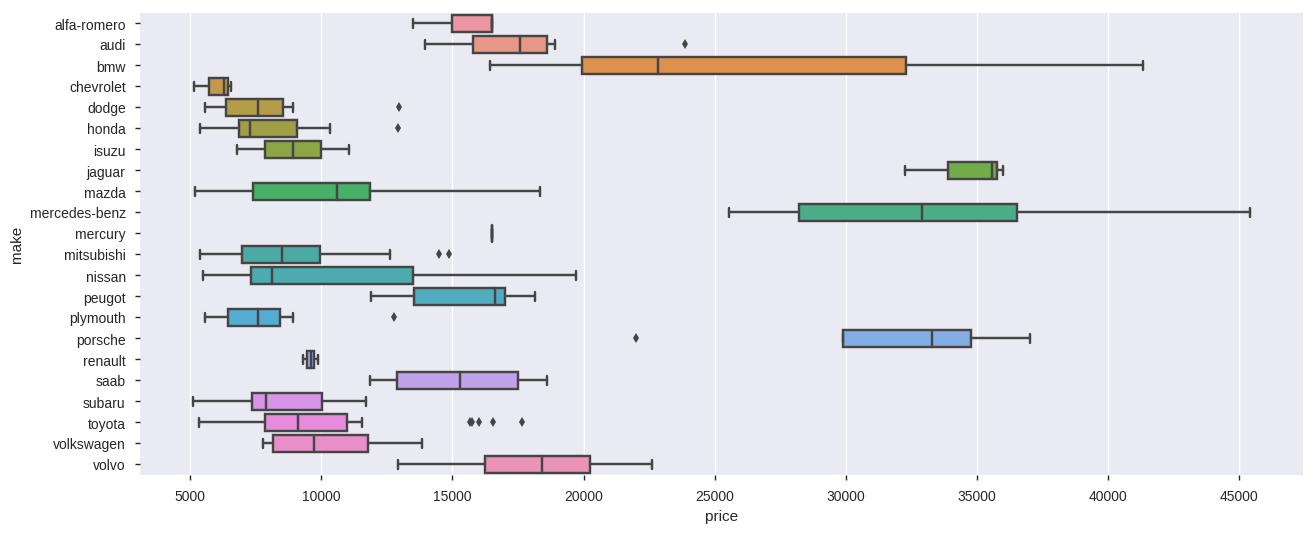

In [173]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'make', data = data_treat1)

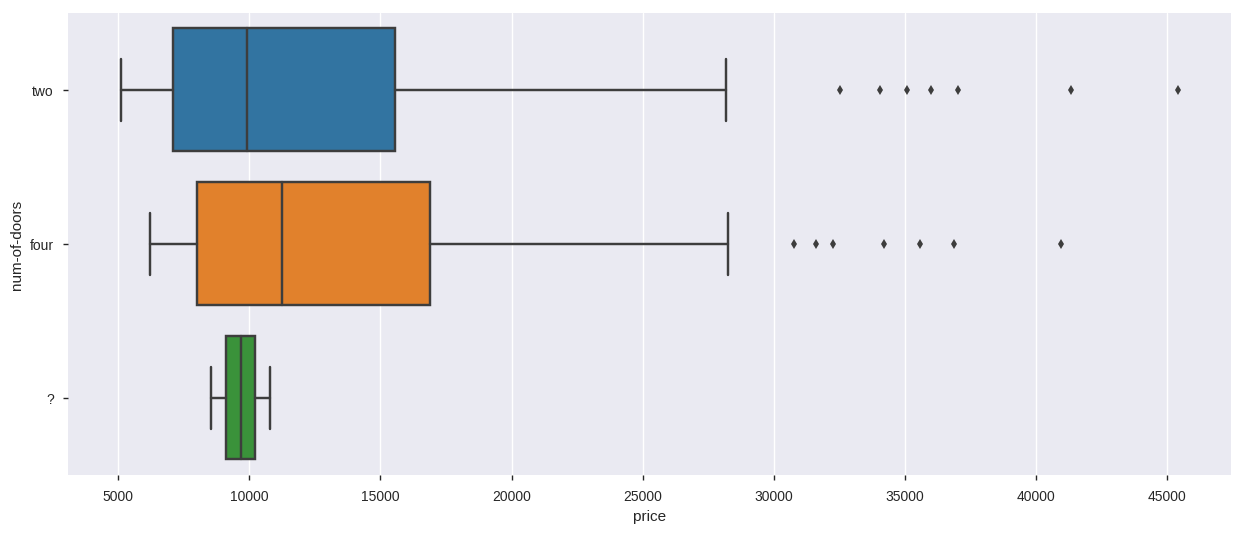

In [174]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'num-of-doors', data = data_treat1)

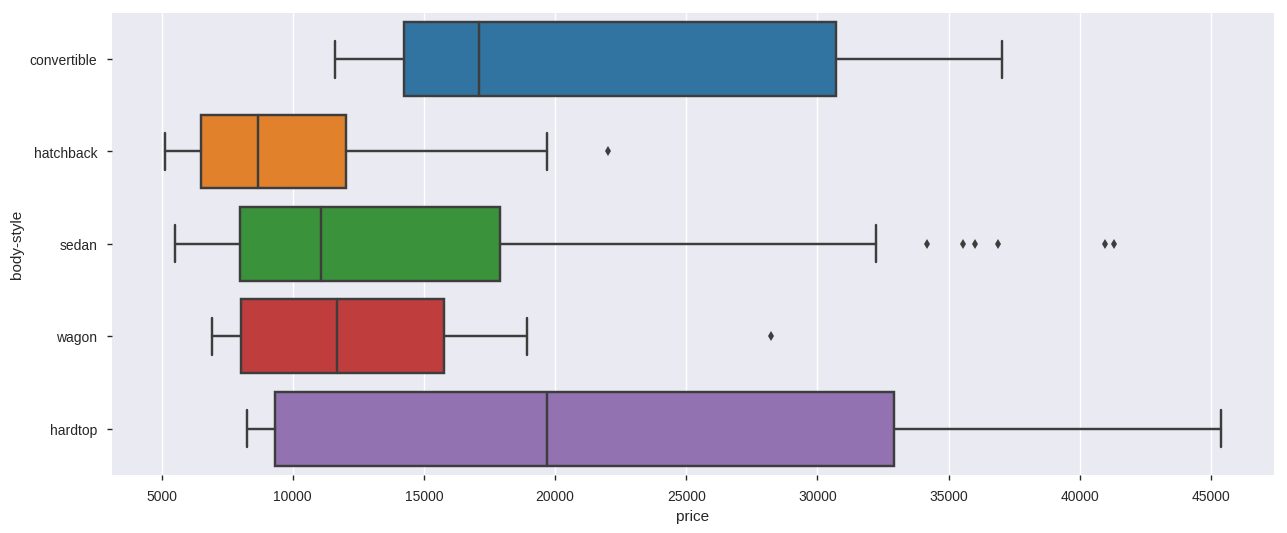

In [175]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'body-style', data = data_treat1)

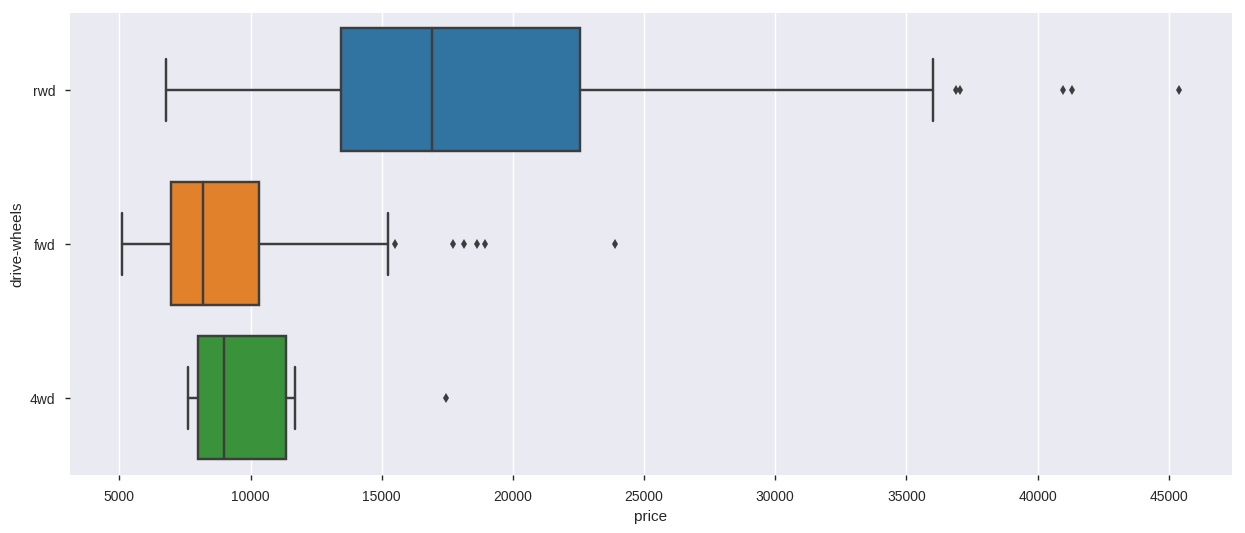

In [176]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'drive-wheels', data = data_treat1)

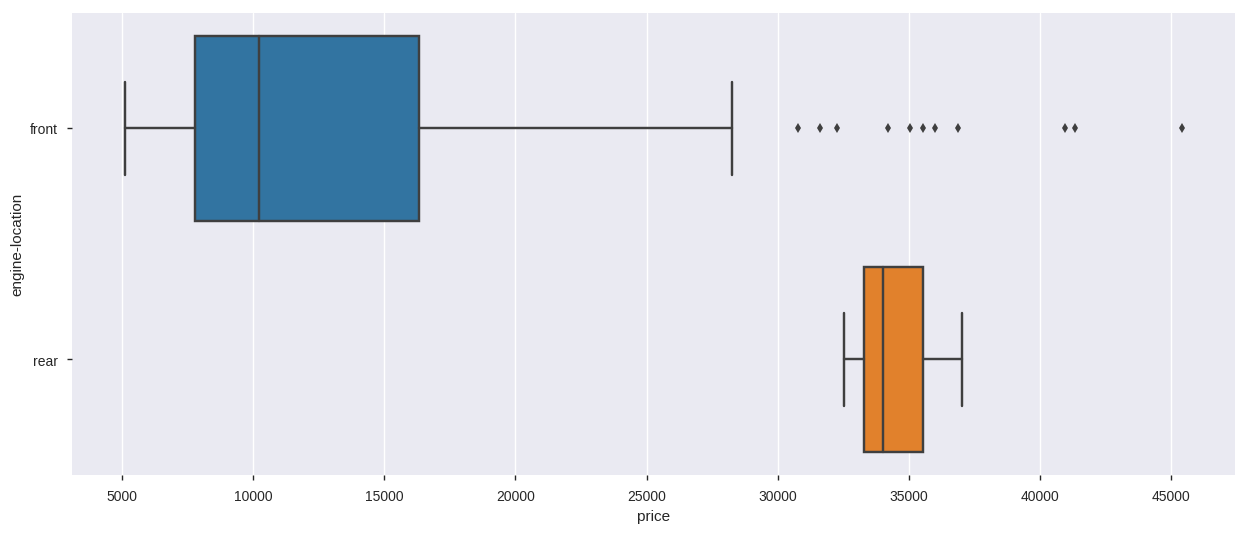

In [178]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'engine-location', data = data_treat1)

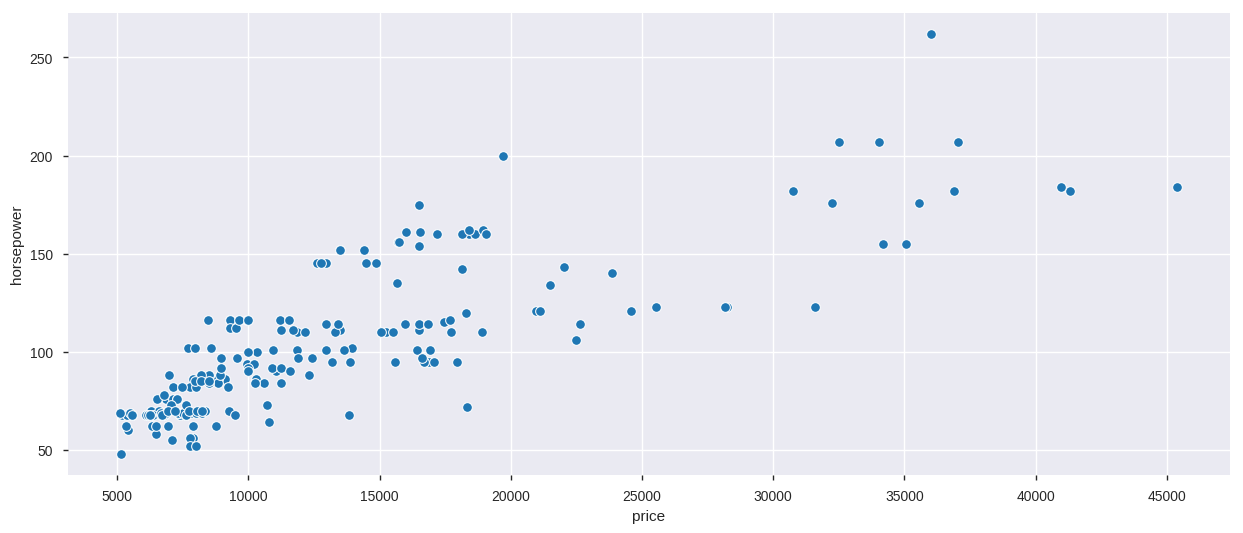

In [179]:
plt.figure(figsize=(15,6))
sns.scatterplot(x = 'price', y = 'horsepower', data = data_treat1)

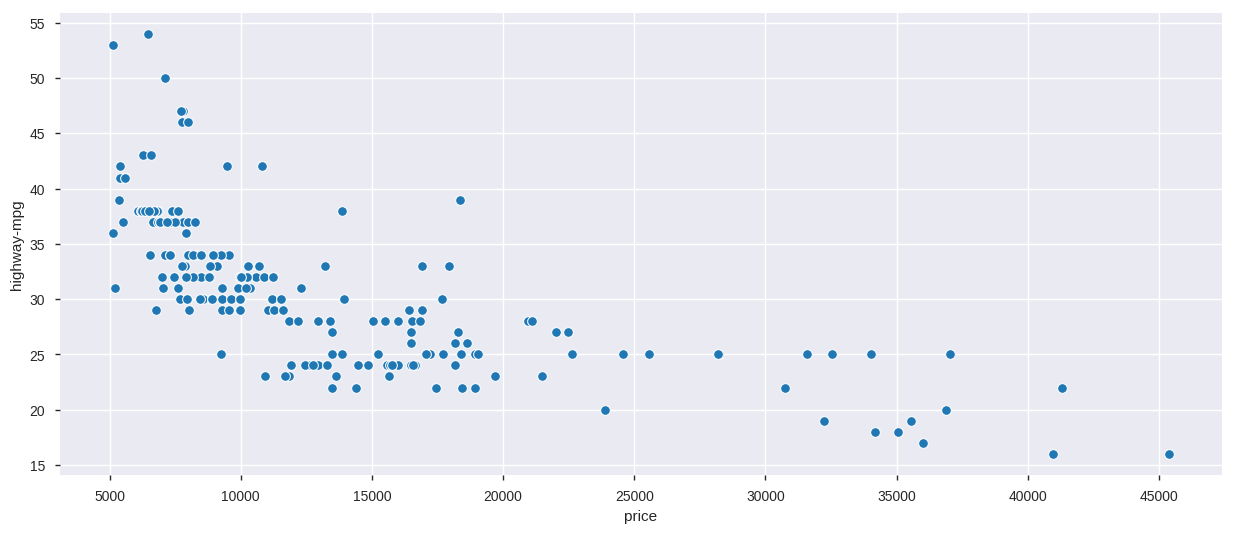

In [182]:
plt.figure(figsize=(15,6))
sns.scatterplot(x = 'price', y = 'highway-mpg', data = data_treat1)

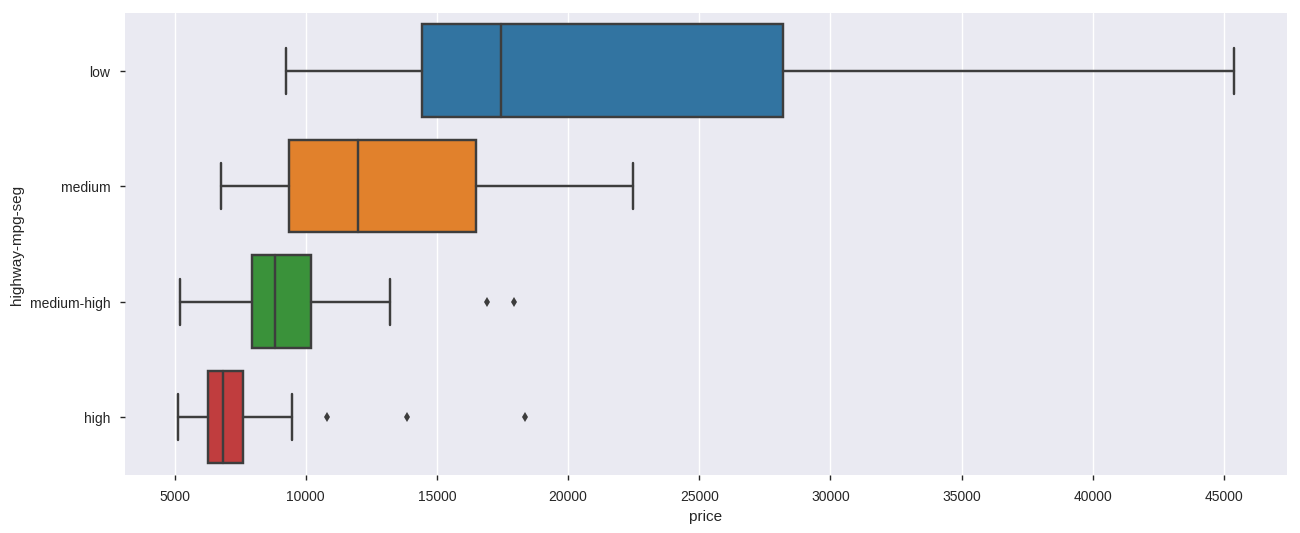

In [194]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'highway-mpg-seg', data = data_treat1)

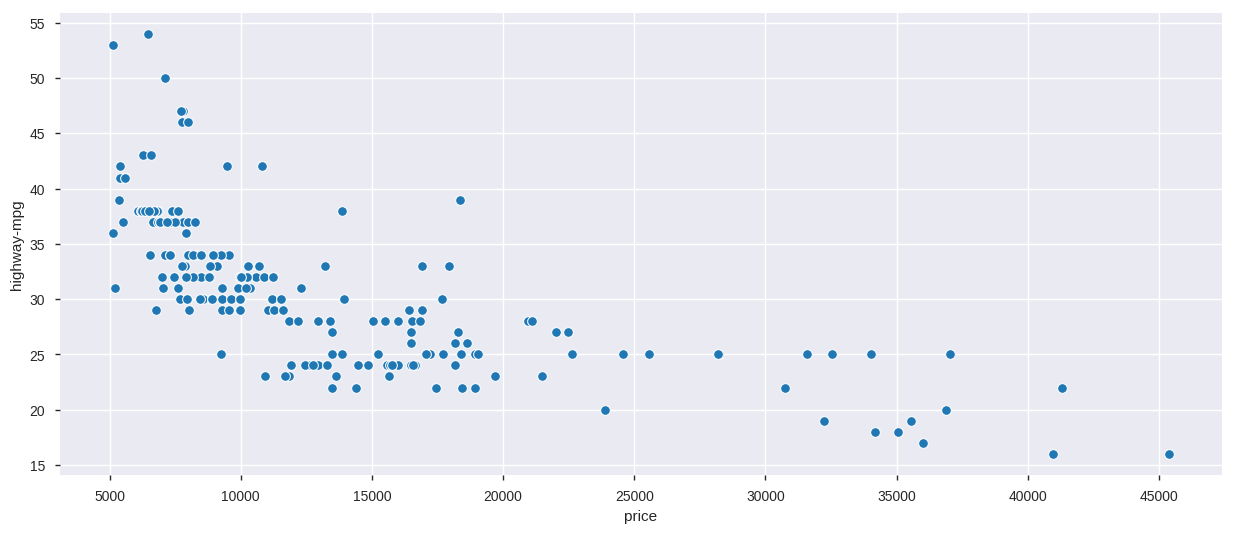

In [183]:
plt.figure(figsize=(15,6))
sns.scatterplot(x = 'price', y = 'highway-mpg', data = data_treat1)

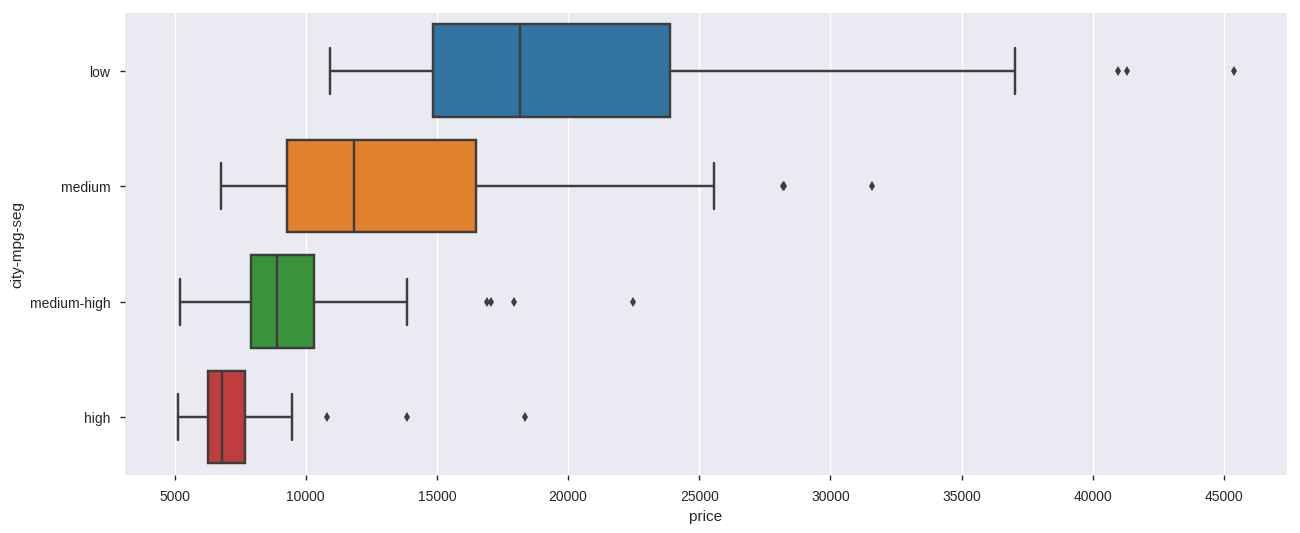

In [195]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'city-mpg-seg', data = data_treat1)

In [189]:
sym_str = [str(s) for s in data_treat1['symboling']]

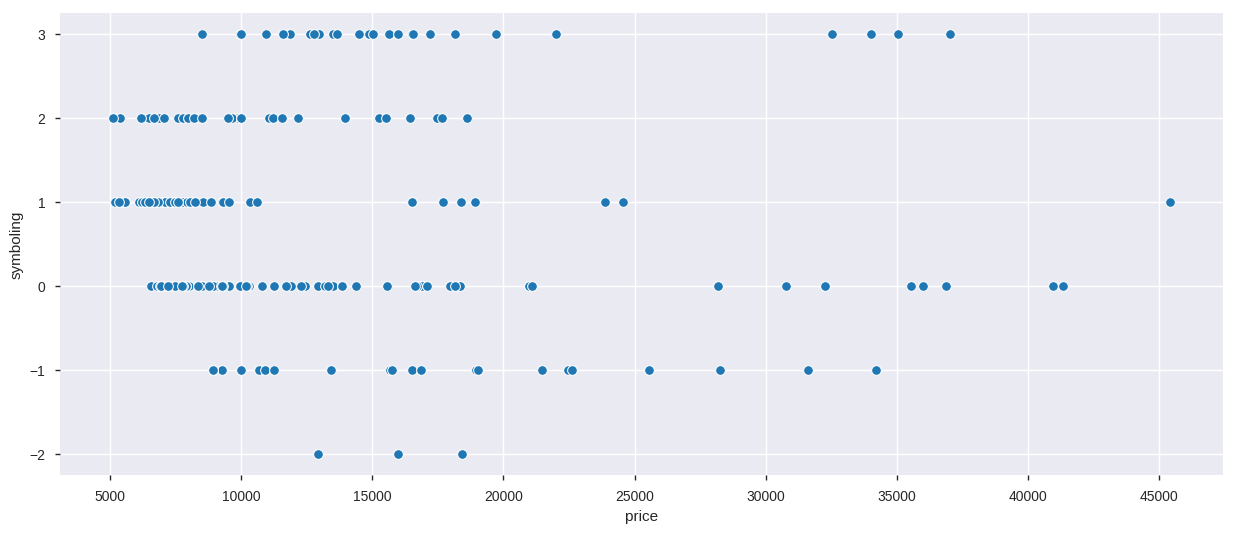

In [197]:
plt.figure(figsize=(15,6))
sns.scatterplot(x = 'price', y ='symboling', data = data_treat1)

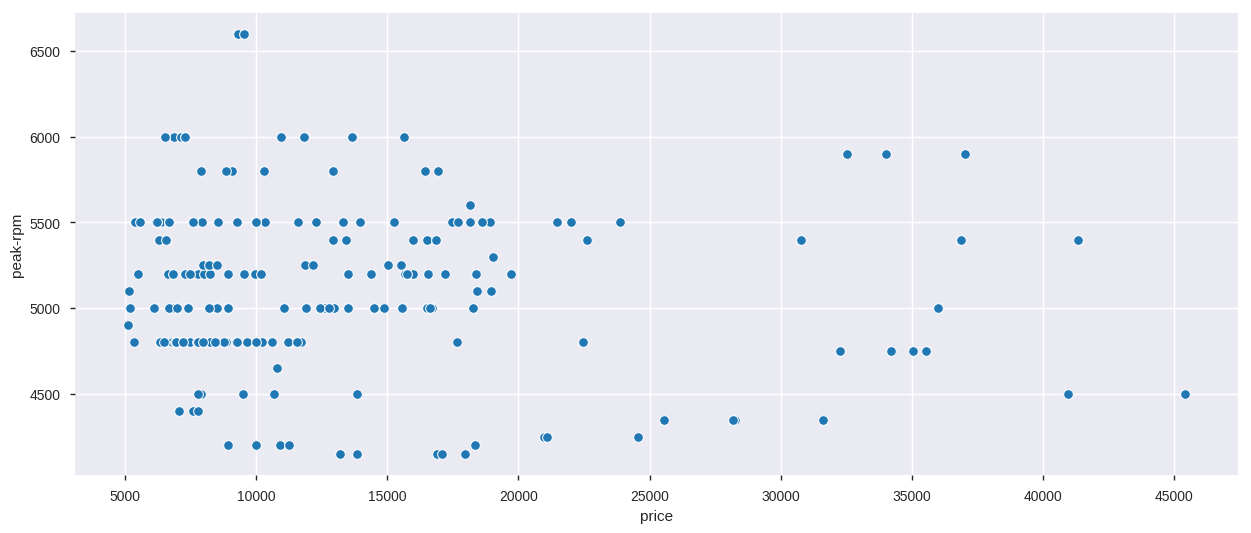

In [196]:
plt.figure(figsize=(15,6))
sns.scatterplot(x = 'price', y ='peak-rpm', data = data_treat1)

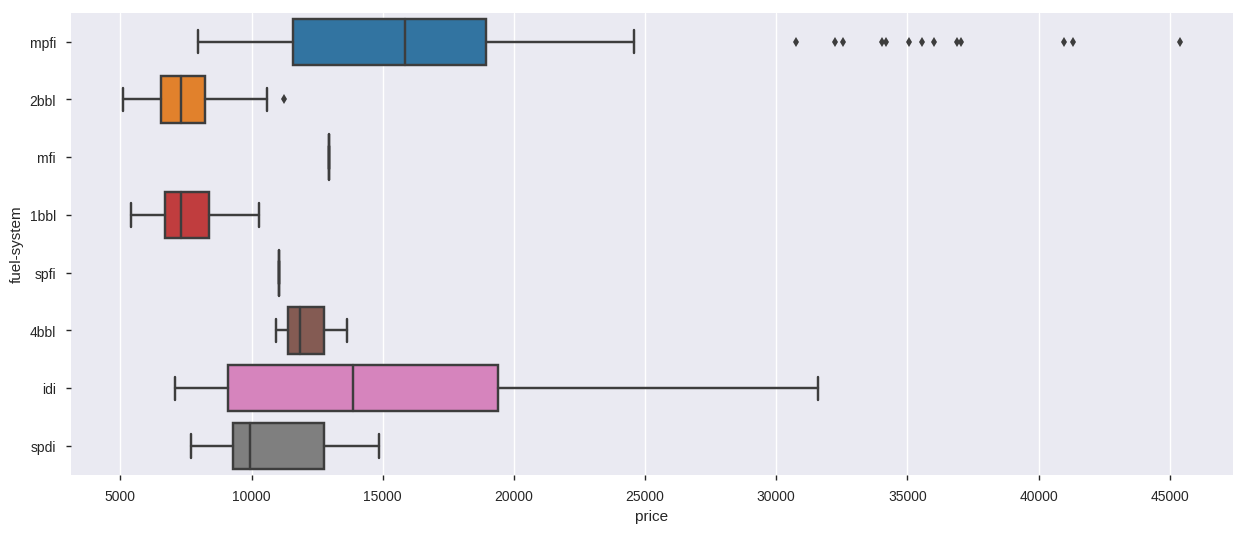

In [199]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'fuel-system', data = data_treat1)

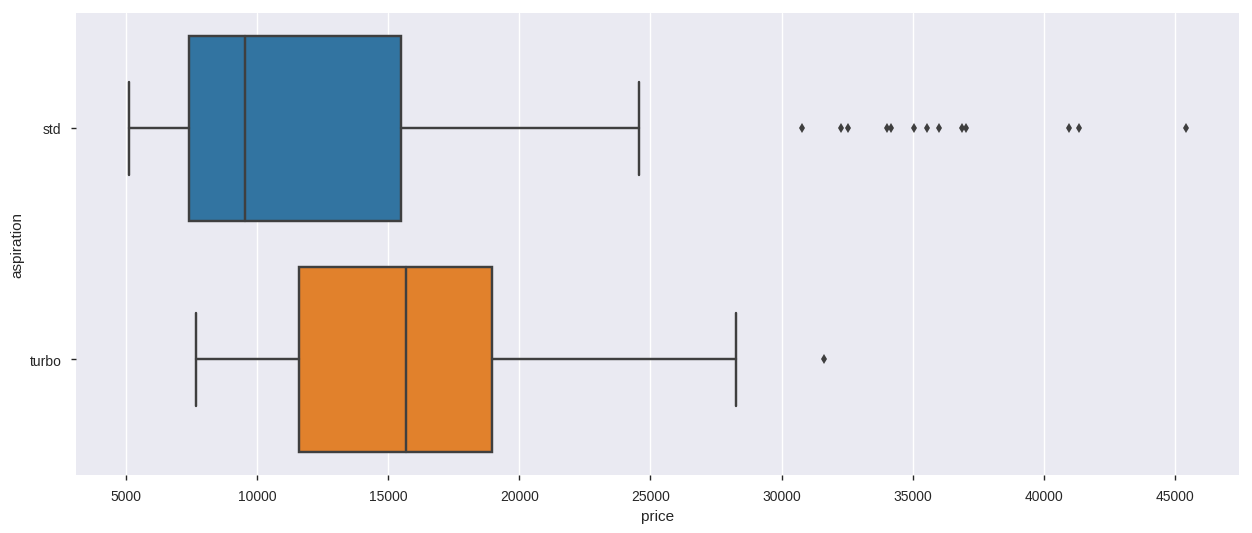

In [200]:
plt.figure(figsize=(15,6))
sns.boxplot(x = 'price', y = 'aspiration', data = data_treat1)